<a href="https://colab.research.google.com/github/pranshurastogi29/Data-science-interview-assignments/blob/main/matelabs_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  ## Hi 
  I am pranshu rastogi, I am in my 3rd year starting and here is my assignment on the problem provided to me.
  [file](https://drive.google.com/drive/folders/1TlI6y_eWYHxm-orqJB0I_maOyS0WmJdy) 
  I hereby thanks to the team for giving me this problem and i have tried my best to model the task and if you find something that is should be improved then plz do tell me if time allows because i want to improve and polish my skills as much as possible
  #### Thank you

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=b28065a09ee74ca694063a217e5c320dd6c5d57bb67675a6585086c9afdbfb16
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
import numpy as np
print('numpy version\t:',np.__version__)
import pandas as pd
print('pandas version\t:',pd.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from scipy.stats import rankdata
import lightgbm as lgb
from sklearn import metrics
import gc
import warnings

# Regular expressions
import re

# seaborn : advanced visualization
import seaborn as sns
print('seaborn version\t:',sns.__version__)

pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.4f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', 100) # to display all the columns

np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

import os

import warnings
warnings.filterwarnings('ignore') # if there are any warning due to version mismatch, it will be ignored

numpy version	: 1.18.5
pandas version	: 1.0.5
seaborn version	: 0.10.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset Preparation & pre-processing

1. Since the data is very much splitted into different csv file the first problem that i have faced is to get a common data csv so its easy for me to analyze the data 

2. According to the Er diagram there are different keys which have relations to every different csv files. we merge the main dataset (train) with other datasets on the columns of campaign_id , coupon_id , customer_id , item_id 

In [ ]:
path = '/content/drive/My Drive/data_problem (3)/data_problem/data'
df = pd.read_csv(path+'/train.csv')
df1 = pd.read_csv(path+'/item_data.csv')
df2 = pd.read_csv(path+'/customer_demographics.csv')
df3 = pd.read_csv(path+'/coupon_item_mapping.csv')
df4 = pd.read_csv(path+'/customer_transaction_data.csv')
df5 = pd.read_csv(path+'/campaign_data.csv')
df = pd.merge(df,df3)
df = pd.merge(df,df5)
df = pd.merge(df,df1)
df = pd.merge(df,df2)
df = pd.merge(df,df4)

In [ ]:
def removeNulls(dataframe, axis =1, percent=0.7):
  
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        print(colnames)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

In [ ]:
df2 = removeNulls(df, axis =1,percent = 0.4)

['no_of_children']
Number of Columns dropped	:  1

Old dataset rows,columns (94855, 23) 
New dataset rows,columns (94855, 22)


First I have removed the nulls because of many different plotting libraries are not compatible with nulls though we have to remove the nulls columns with high percentage of not available data points

## UNIVARIATE ANALYSIS
 STARTING WITH UNIVARIATE ANALYSIS

### Continuous Variables

In case of continuous variables, we need to understand the CENTRAL TENDENCY and SPREAD of the variable. These are measured using various statistical metrics visualization methods such as BOXPLOT,HISTOGRAM/DISTRIBUTION PLOT, VIOLIN PLOT etc.

### Categorical Variables


For categorical variables, we’ll use frequency table to understand distribution of each category. It can be be measured using two metrics, COUNT and COUNT% against each category. COUNTBARPLOT or BAR CHART can be used as visualization.


In [ ]:
def plotting_3_chart(df, feature): 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    fig = plt.figure(constrained_layout=True, figsize=(7,7))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title(feature + ' Histogram')
    sns.distplot(df.loc[:,feature], fit = stats.norm,norm_hist=True, ax = ax1)

    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title(feature + ' QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

 
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title(feature + ' Box Plot')
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 )
    k2, p = stats.normaltest(df[feature].values)
    skewness = df[feature].skew()
    kurtosis = df[feature].kurtosis()
    print('\n kurtosis = %.3f,skew = %.3f ,p-value = %.3f' % (kurtosis,skewness,p))

    alpha = 0.05
    if p > alpha:
        print('\nThe transformed data is Gaussian (fails to reject the null hypothesis)')
    else:
        print('\nThe transformed data does not look Gaussian (reject the null hypothesis)')

In [ ]:
def univariate(df,col,vartype,hue =None):
  
    sns.set(style="darkgrid")
    
    if vartype == 0:
        plotting_3_chart(df,col)
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()


 kurtosis = 67.658,skew = 5.480 ,p-value = 0.000

The transformed data does not look Gaussian (reject the null hypothesis)


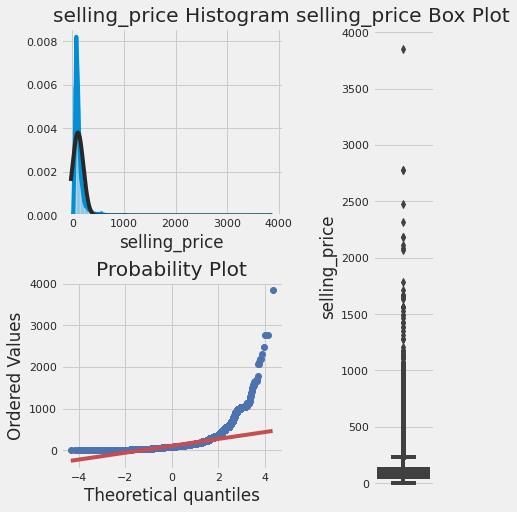

In [ ]:
import seaborn as sns
univariate(df=df2,col='selling_price',vartype=0)

Here we have seen that the selling price is skewed and the qq plot shows that the data is also not very much normally distributed also there are many outliers in the series you can see it in the boxplots


 kurtosis = 63.774,skew = -5.402 ,p-value = 0.000

The transformed data does not look Gaussian (reject the null hypothesis)


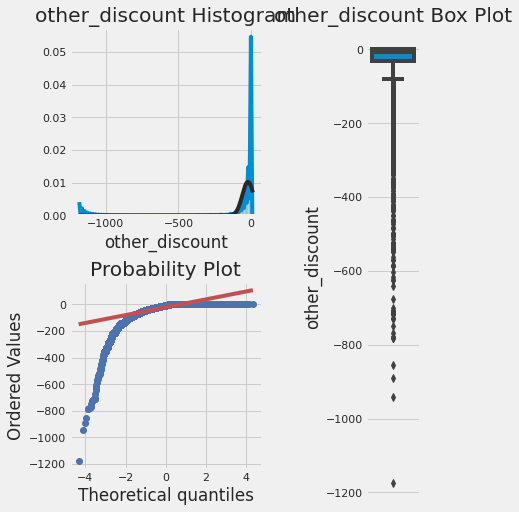

In [ ]:
import seaborn as sns
univariate(df=df2,col='other_discount',vartype=0)

In [ ]:
def transform_plot(df2,cols):
    df = df2
    if cols == 'other_discount':
        df2[cols] = -1 * df2[cols]
    plt.figure(figsize=(16,12))
    plt.suptitle('price Values Distribution', fontsize=22)
    plt.subplot(221)
    g = sns.distplot(df2[cols])
    g.set_title(cols, fontsize=18)
    g.set_xlabel("")
    g.set_ylabel("Probability", fontsize=15)
    
    plt.subplot(222)
    g1 = sns.distplot(np.log(df2[cols]))
    g1.set_title(cols + " (Log) Distribuition", fontsize=18)
    g1.set_xlabel("")
    g1.set_ylabel("Probability", fontsize=15)
    
    plt.figure(figsize=(16,12))
    
    
    plt.subplot(212)
    g4 = plt.scatter(range(df2[df2['redemption_status'] == 0].shape[0]),
                     np.sort(df2[df2['redemption_status'] == 0][cols].values), 
                     label='no_redemption_status', alpha=.2)
    g4 = plt.scatter(range(df2[df2['redemption_status'] == 1].shape[0]),
                     np.sort(df2[df['redemption_status'] == 1][cols].values), 
                     label='redemption_status', alpha=.2)
    g4= plt.title(cols + "Distribution", fontsize=18)
    g4 = plt.xlabel("Index")
    g4 = plt.ylabel(cols + "Distribution", fontsize=15)
    g4 = plt.legend()
    
    plt.figure(figsize=(16,12))
    
    plt.subplot(321)
    g = plt.scatter(range(df2[df2['redemption_status'] == 1].shape[0]), 
                     np.sort(df[df['redemption_status'] == 1][cols].values), 
                    label='redemption_status', alpha=.4)
    plt.title("redemption_status", fontsize=18)
    plt.xlabel("Index")
    plt.ylabel(cols + "Distribution", fontsize=12)
    
    plt.subplot(322)
    g1 = plt.scatter(range(df[df['redemption_status'] == 0].shape[0]),
                     np.sort(df[df['redemption_status'] == 0][cols].values), 
                     label='no_redemption_status', alpha=.2)
    g1= plt.title("redemption_status", fontsize=18)
    g1 = plt.xlabel("Index")
    g1 = plt.ylabel(cols + "Distribution", fontsize=15)
    
    plt.suptitle('Individual Distribution', fontsize=22)
    
    plt.show()
    

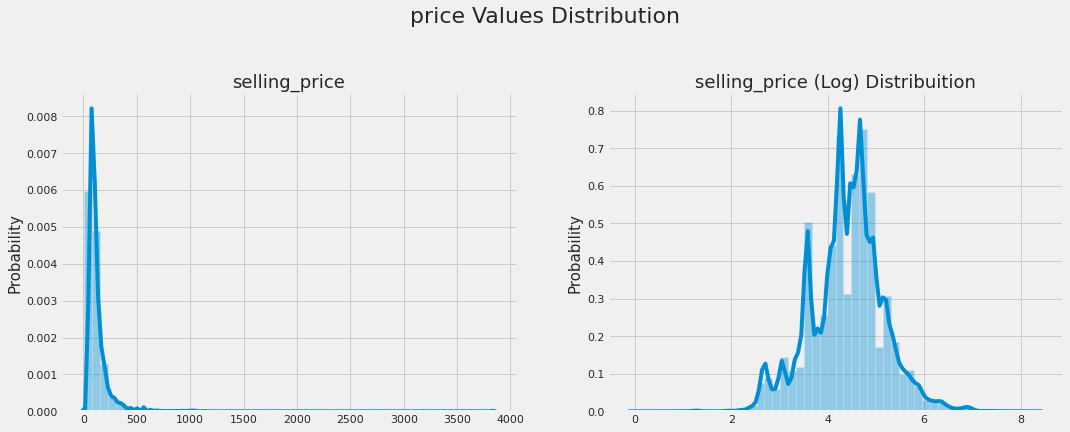

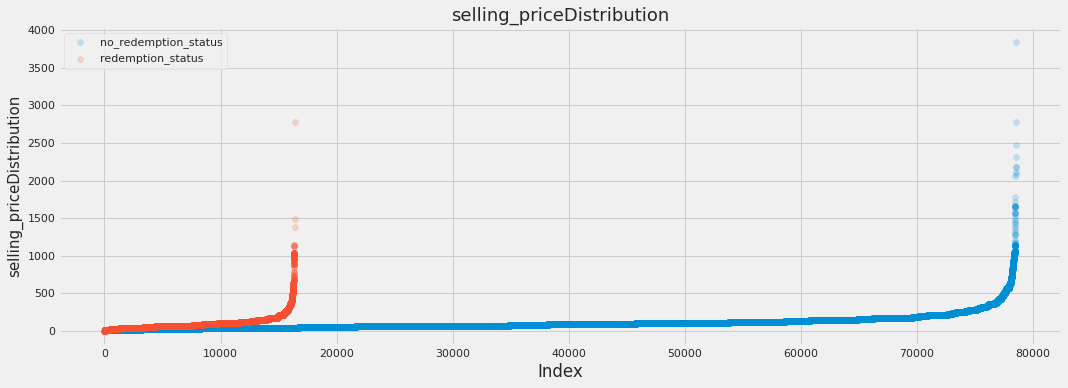

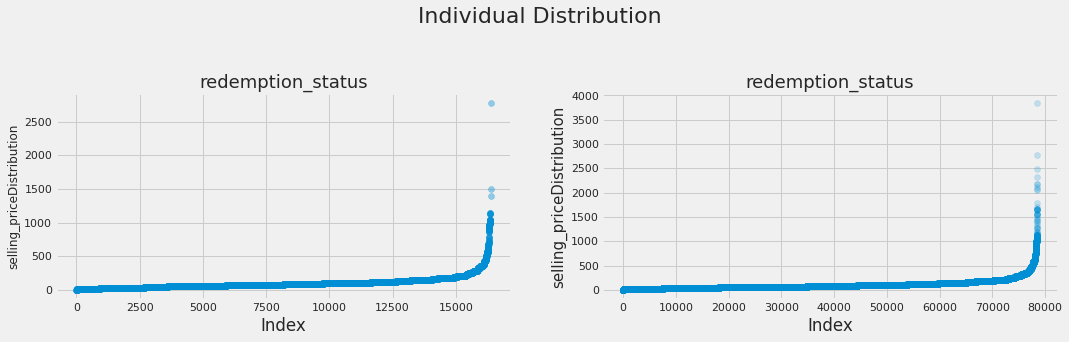

In [ ]:
transform_plot(df,'selling_price')

So what we have seen the original selling price distributions that are skewed , now we have applied a very know transformation of converting the data into log form and now this shows some variability also in the other plots the orange and blue points shows that there is same distribution either is same i will show you some more evidance on it in the latter sections of notebook

In [ ]:
def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) 
    print('Identified upper outliers: %d' % len(outliers_higher)) 
    print('Total outlier observations: %d' % len(outliers_total)) 
    print('Non-outlier observations: %d' % len(outliers_removed)) 
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4))
    
    return


In [ ]:
CalcOutliers(df['other_discount'])

Identified lowest outliers: 1781
Identified upper outliers: 0
Total outlier observations: 1781
Non-outlier observations: 93074
Total percentual of Outliers:  1.9135


In [ ]:
CalcOutliers(df['selling_price'])

Identified lowest outliers: 0
Identified upper outliers: 1694
Total outlier observations: 1694
Non-outlier observations: 93161
Total percentual of Outliers:  1.8184


aah here you can see the number of outliers that was shown in the univariate analysis of the same variable but i am not removing it because of some rows might get deleted which could lead to loss of some customer_ids and coupon_ids because some of the ids are very less in number

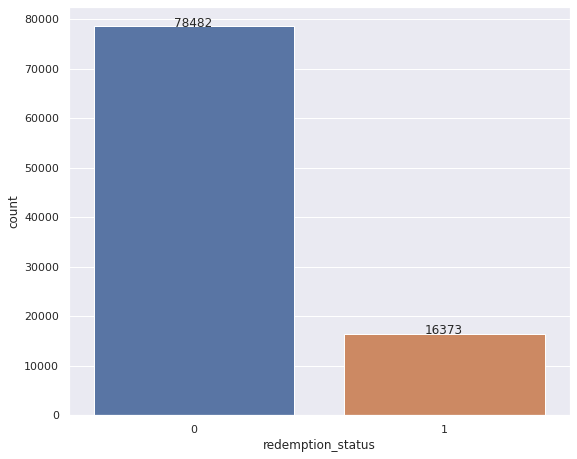

In [ ]:
univariate(df=df,col='redemption_status',vartype=1)

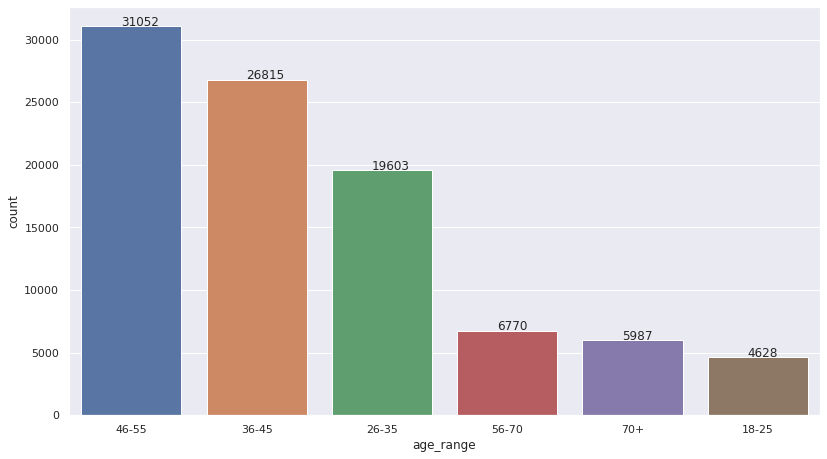

In [ ]:
univariate(df=df,col='age_range',vartype=1)


 kurtosis = 5.495,skew = 2.245 ,p-value = 0.000

The transformed data does not look Gaussian (reject the null hypothesis)


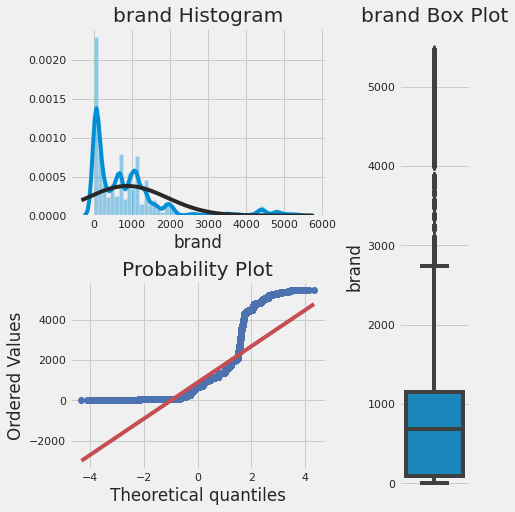

In [ ]:
univariate(df=df,col='brand',vartype=0)

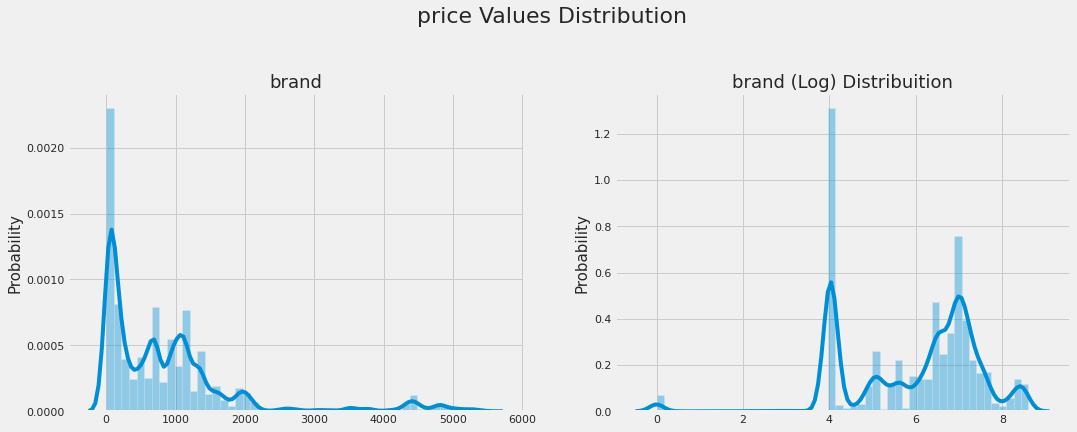

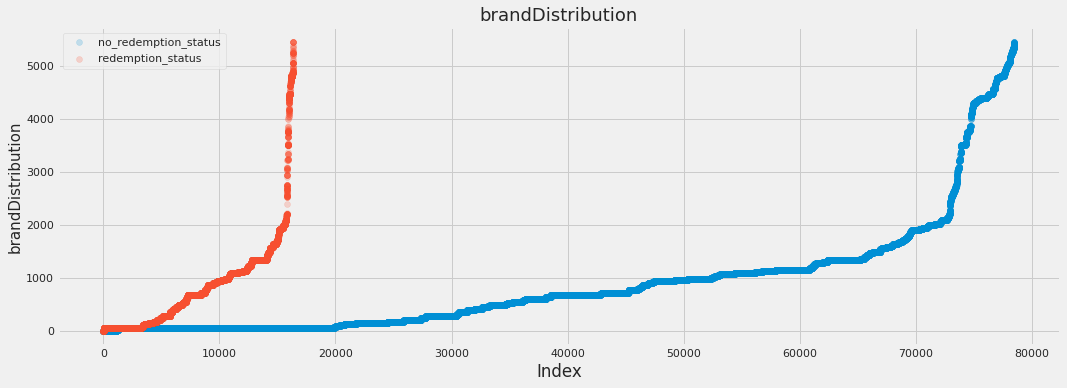

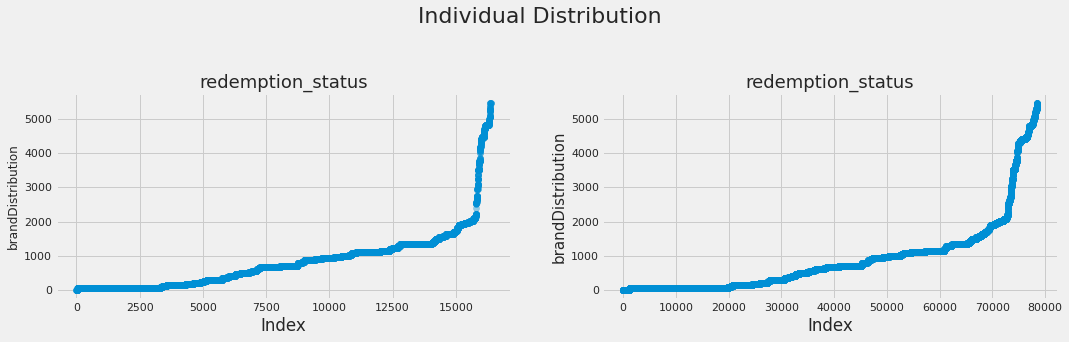

In [ ]:
transform_plot(df,'brand')

pardon for this graph this is for column 'brand' which should be categorical but there are too many categories so this makes to think in other way as treating them as continous variable which makes very less sense but still ;)

In [ ]:
df

,id,campaign_id,coupon_id,customer_id,redemption_status,item_id,campaign_type,start_date,end_date,brand,brand_type,category,age_range,marital_status,rented,family_size,no_of_children,income_bracket,date,quantity,selling_price,other_discount,coupon_discount
0,121392,13,126,1053,0,32518,X,19/05/13,05/07/13,56,Local,Grocery,46-55,NaN,0,1,NaN,5,2013-05-11,1,35.6200,-28.1400,0.0000
1,68170,13,22,1053,0,4404,X,19/05/13,05/07/13,1050,Established,Grocery,46-55,NaN,0,1,NaN,5,2012-11-14,1,60.2000,0.0000,0.0000
2,68170,13,22,1053,0,16621,X,19/05/13,05/07/13,1367,Established,Grocery,46-55,NaN,0,1,NaN,5,2012-01-10,1,89.0500,-10.3300,0.0000
3,68170,13,22,1053,0,28794,X,19/05/13,05/07/13,56,Local,Grocery,46-55,NaN,0,1,NaN,5,2012-12-15,1,71.2400,-70.8800,0.0000
4,68170,13,22,1053,0,47950,X,19/05/13,05/07/13,56,Local,Grocery,46-55,NaN,0,1,NaN,5,2012-01-10,1,99.3800,-42.7400,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94850,48192,30,522,1256,0,27435,X,19/11/12,04/01/13,971,Established,Grocery,36-45,NaN,0,1,NaN,4,2013-06-07,1,71.2400,-49.5100,0.0000
94851,105287,10,689,52,0,33480,Y,08/04/13,10/05/13,686,Established,Pharmaceutical,36-45,Married,0,5+,3+,7,2012-12-25,1,498.3200,-71.2400,0.0000
94852,105287,10,689,52,0,62261,Y,08/04/13,10/05/13,686,Established,Pharmaceutical,36-45,Married,0,5+,3+,7,2012-04-20,1,284.6000,-71.2400,0.0000
94853,89174,10,824,52,0,13947,Y,08/04/13,10/05/13,57,Established,Grocery,36-45,Married,0,5+,3+,7,2012-04-03,1,167.0600,-64.1200,0.0000


<Figure size 432x288 with 0 Axes>

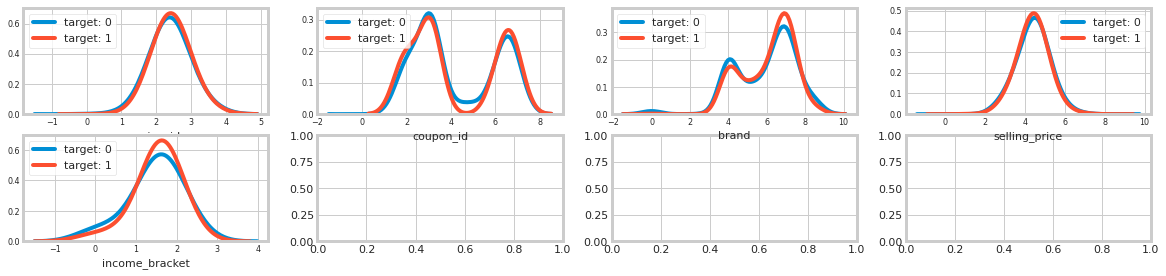

In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,4))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(np.log(df1[feature]), bw=0.5,label=label1)
        sns.kdeplot(np.log(df2[feature]), bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

t0 = df.loc[df['redemption_status'] == 0]
t1 = df.loc[df['redemption_status'] == 1]
features = ['campaign_id','coupon_id','brand','selling_price','income_bracket']
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Here are some of the distributions segregated according to the classes 
some of the distributions are of categorical variables but when i plot some of the categoricals i saw some good and interesting patterns here are some them
1. First i have showed you the distributions of the categories of campaign_id in both of the target labels both of them is the same 
2. Same happening with the coupon_id and brand
3. while the selling price too shows the same distribution which is explainable because of its continuous nature but if we take the categories as a number then they too are explainable 

have an idea do share with me 

## Some more Univariates

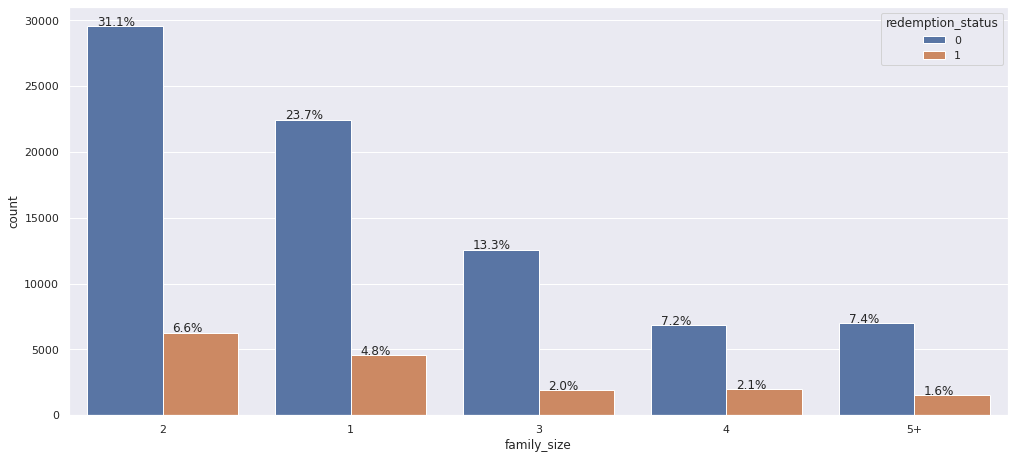

In [ ]:
univariate(df=df,col='family_size',vartype=1,hue='redemption_status')

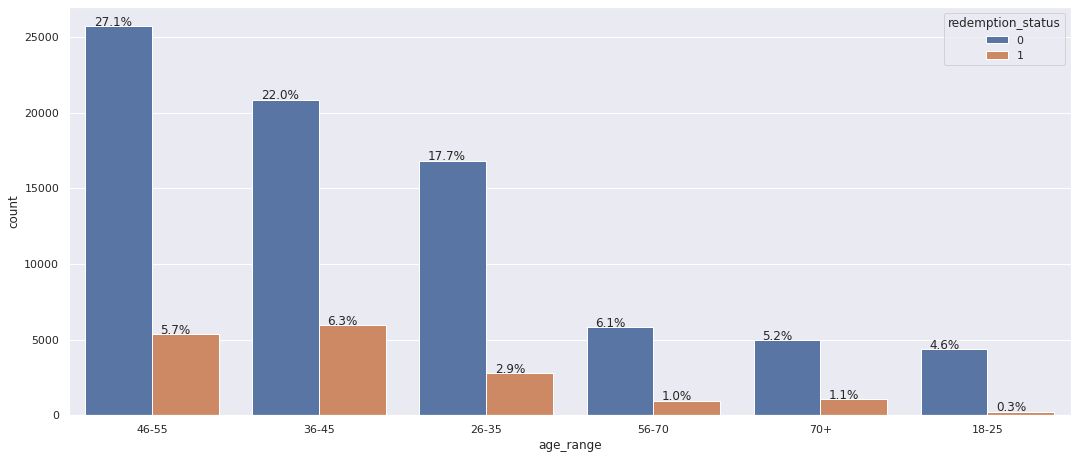

In [ ]:
univariate(df=df,col='age_range',vartype=1,hue='redemption_status')

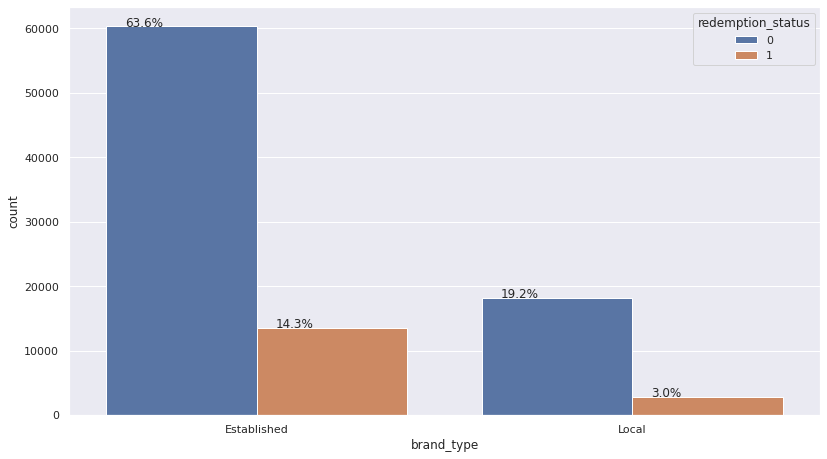

In [ ]:
univariate(df=df,col='brand_type',vartype=1,hue='redemption_status')

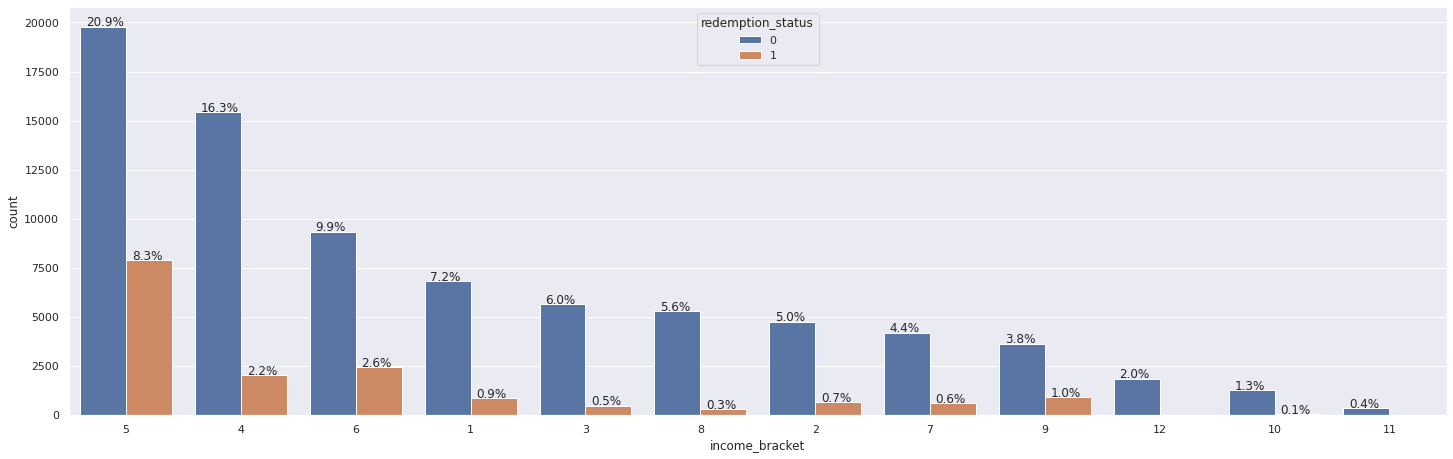

In [ ]:
univariate(df=df,col='income_bracket',vartype=1,hue='redemption_status')

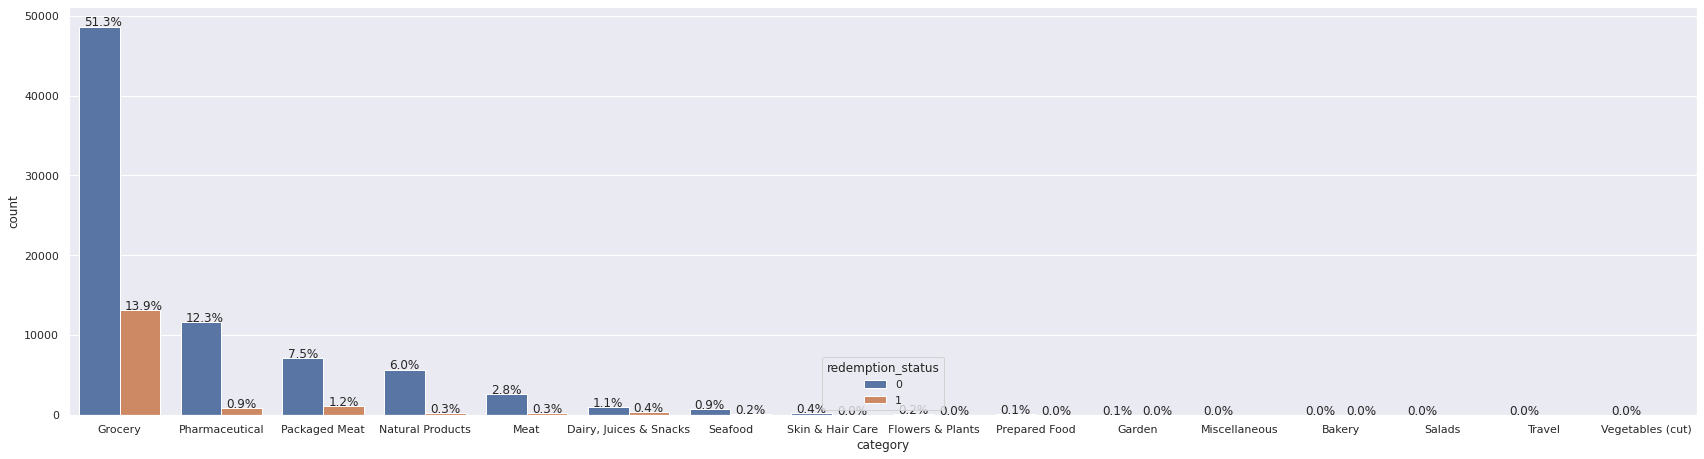

In [ ]:
univariate(df=df,col='category',vartype=1,hue='redemption_status')

## Feature Engineering (not very heavy though ;))

In [ ]:
# label encoding every categorical variable
from sklearn import preprocessing
v = {}
df = df.fillna('null')
for i in ['id','campaign_id','coupon_id','customer_id','category','age_range','no_of_children','marital_status','quantity','item_id','campaign_type','brand','brand_type','rented','family_size']:
    le = preprocessing.LabelEncoder()
    le.fit(df[i].values)
    df[i] = le.transform(df[i].values)
    v[i] = [le]

NameError: ignored

In [ ]:
# log transforming and creating new features
df['selling_price'] = np.log(df['selling_price'])
df['other_discount'] = -1*df['other_discount']
df['discounted_rate'] = ((df['selling_price']-df['other_discount'])/len(df['selling_price']))*100

df['selling_price'] = df['selling_price']/df['selling_price'].max()
df['other_discount'] = np.log(df['other_discount'])
df['other_discount'] = df['other_discount']/df['other_discount'].max()

NameError: ignored

In [ ]:
def conv(x):
    a = x.split('/')
    a[-1]='20'+ a[-1]
    return a[0]+'/'+a[1]+'/'+a[-1]

In [ ]:
df['start_date'] = df['start_date'].apply(lambda x:conv(x))

In [ ]:
df['end_date'] = df['end_date'].apply(lambda x:conv(x))

In [ ]:
df['start_date'] = pd.to_datetime(df['start_date'],format='%d/%m/%Y')
df['end_date'] = pd.to_datetime(df['end_date'],format='%d/%m/%Y')
df['date'] = pd.to_datetime(df['date'],format='%Y/%m/%d')

In [ ]:
# features related to the dates so creating some new features
# converting the dates into years and months making new features out of them

df['diff'] =  (df['end_date'] - df['start_date'])/ np.timedelta64(1, 'D')
df['diff_yr'] = df['diff']/365
df['diff_mon'] = df['diff']/30
df['diff_week'] = df['diff']/7

df['D_diff'] =  (df['date'] - df['start_date'])/ np.timedelta64(1, 'D')
df['D_diff_yr'] = df['diff']/365
df['D_diff_mon'] = df['diff']/30
df['D_diff_week'] = df['diff']/7

df['d_diff'] =  (df['end_date'] - df['date'])/ np.timedelta64(1, 'D')
df['d_diff_yr'] = df['diff']/365
df['d_diff_mon'] = df['diff']/30
df['d_diff_week'] = df['diff']/7

In [ ]:
df['start_date_yr'] = df['start_date'].dt.year
df['start_date_mon'] = df['start_date'].dt.month
df['start_date_dt'] = df['start_date'].dt.day
df['end_date_yr'] = df['end_date'].dt.year
df['end_date_mon'] = df['end_date'].dt.month
df['end_date_dt'] = df['end_date'].dt.day

df['date_yr'] = df['date'].dt.year
df['date_mon'] = df['date'].dt.month
df['date_dt'] = df['date'].dt.day

In [ ]:
df = df.drop(columns=['start_date','end_date','date'])

In [ ]:
df2= df.drop(columns=['marital_status','no_of_children','discounted_rate','other_discount'])

In [ ]:
# PCA just for visualization else not very much
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

PCA_train_x = PCA(3).fit_transform(df2)
fr1 = pd.DataFrame({'tsne1': PCA_train_x[:,0], 'tsne2': PCA_train_x[:, 1], 'tsne3':PCA_train_x[:,2],'cluster': df2['redemption_status']})
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=df2['redemption_status'], cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(fr1, x='tsne1', y='tsne2', z='tsne3',
                    color='cluster',opacity=0.6)
fig.show()

### here is a 3D plots that clearly increases questions than answers ;)

### Now comes the parts of data validation and modelling
1. here i have used 3 techniques for validation 
  1. stratified k fold very normal
  2. group k fold on customer_ids
  3. group k fold on coupon_ids

2. modeled the task with LGBM and hyperparameter tunning with bayes optimization in every case

------------------------------------------------------------------------------------
1. Bayes optimization on LGBM with startified K FOLD

In [ ]:
##splitting the data for finding better hyperparamters
df1 = df.drop(columns=['redemption_status'])
predictors = df1.columns[2:]
target = 'redemption_status'
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(df1[predictors], df[target].values))[0]

In [ ]:
train_df = df1[predictors]
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,   

    }    
    
    
    xg_train = lgb.Dataset(df1.iloc[bayesian_tr_index][predictors].values,
                           label=df.iloc[bayesian_tr_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(df1.iloc[bayesian_val_index][predictors].values,
                           label=df.iloc[bayesian_val_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )   

    num_round = 5000
    clf = lgb.train(param, xg_train, num_round, valid_sets =[xg_valid], verbose_eval=250, early_stopping_rounds = 200)
    
    predictions = clf.predict(df1.iloc[bayesian_val_index][predictors].values, num_iteration=clf.best_iteration)   
    
    score = metrics.roc_auc_score(df.iloc[bayesian_val_index][target].values, predictions)
    
    return score


In [ ]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15),}

In [ ]:
from bayes_opt import BayesianOptimization
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)

In [ ]:
print(LGB_BO.space.keys)

In [ ]:
init_points = 10
n_iter = 5

print('-' * 130)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

In [ ]:
# parameters that produce best results on auc
LGB_BO.max['params']

In [ ]:
LGB_BO.probe(
    params={'feature_fraction': LGB_BO.max['params']['feature_fraction'], 
            'lambda_l1':LGB_BO.max['params']['lambda_l1'], 
            'lambda_l2': LGB_BO.max['params']['lambda_l2'], 
            'learning_rate': LGB_BO.max['params']['learning_rate'], 
            'max_depth': LGB_BO.max['params']['max_depth'], 
            'min_data_in_leaf': LGB_BO.max['params']['min_data_in_leaf'] ,
            'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'], 
            'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'], 
            'num_leaves': LGB_BO.max['params']['num_leaves']},
    lazy=True,
)

In [ ]:
LGB_BO.maximize(init_points=0, n_iter=0) # remember no init_points or n_iter

In [ ]:
for i, res in enumerate(LGB_BO.res):
    print("Iteration {}: \n\t{}".format(i, res))

In [ ]:
LGB_BO.max['target']

In [ ]:
LGB_BO.max['params']

In [ ]:
param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), # remember to int here
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), # remember to int here
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), # remember to int here
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False}

Since we have got the tuned parameters so now lets train the model

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)

oof = np.zeros(len(train_df))
#predictions = np.zeros((len(test_df),nfold))
feature_importance_df = pd.DataFrame()
    
i = 1
for train_index, valid_index in skf.split(df1[predictors], df[target].values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(df1.iloc[train_index][predictors].values,
                           label=df.iloc[train_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(df1.iloc[valid_index][predictors].values,
                           label=df.iloc[valid_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )   

    
    clf = lgb.train(param_lgb, xg_train, 5000, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    oof[valid_index] = clf.predict(df1.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = i
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions[:,i-1] += clf.predict(test_df[predictors], num_iteration=clf.best_iteration)
    i = i + 1

print("\n\nCV AUC: {:<0.2f}".format(metrics.roc_auc_score(df[target].values, oof)))

### wow CV is of 1.00 with 10 fold so now lets see the model features importance

1. checking if there is a leek in the training for these results to come
2. datasets used are df and df1
3. df1 in training and df for target values


In [ ]:
print(predictors)
## these are the columns of df1 that the model is trained on
df1['redemption_status']
# this shows that we donot have a leaking in the training

## feature importance in this scenario

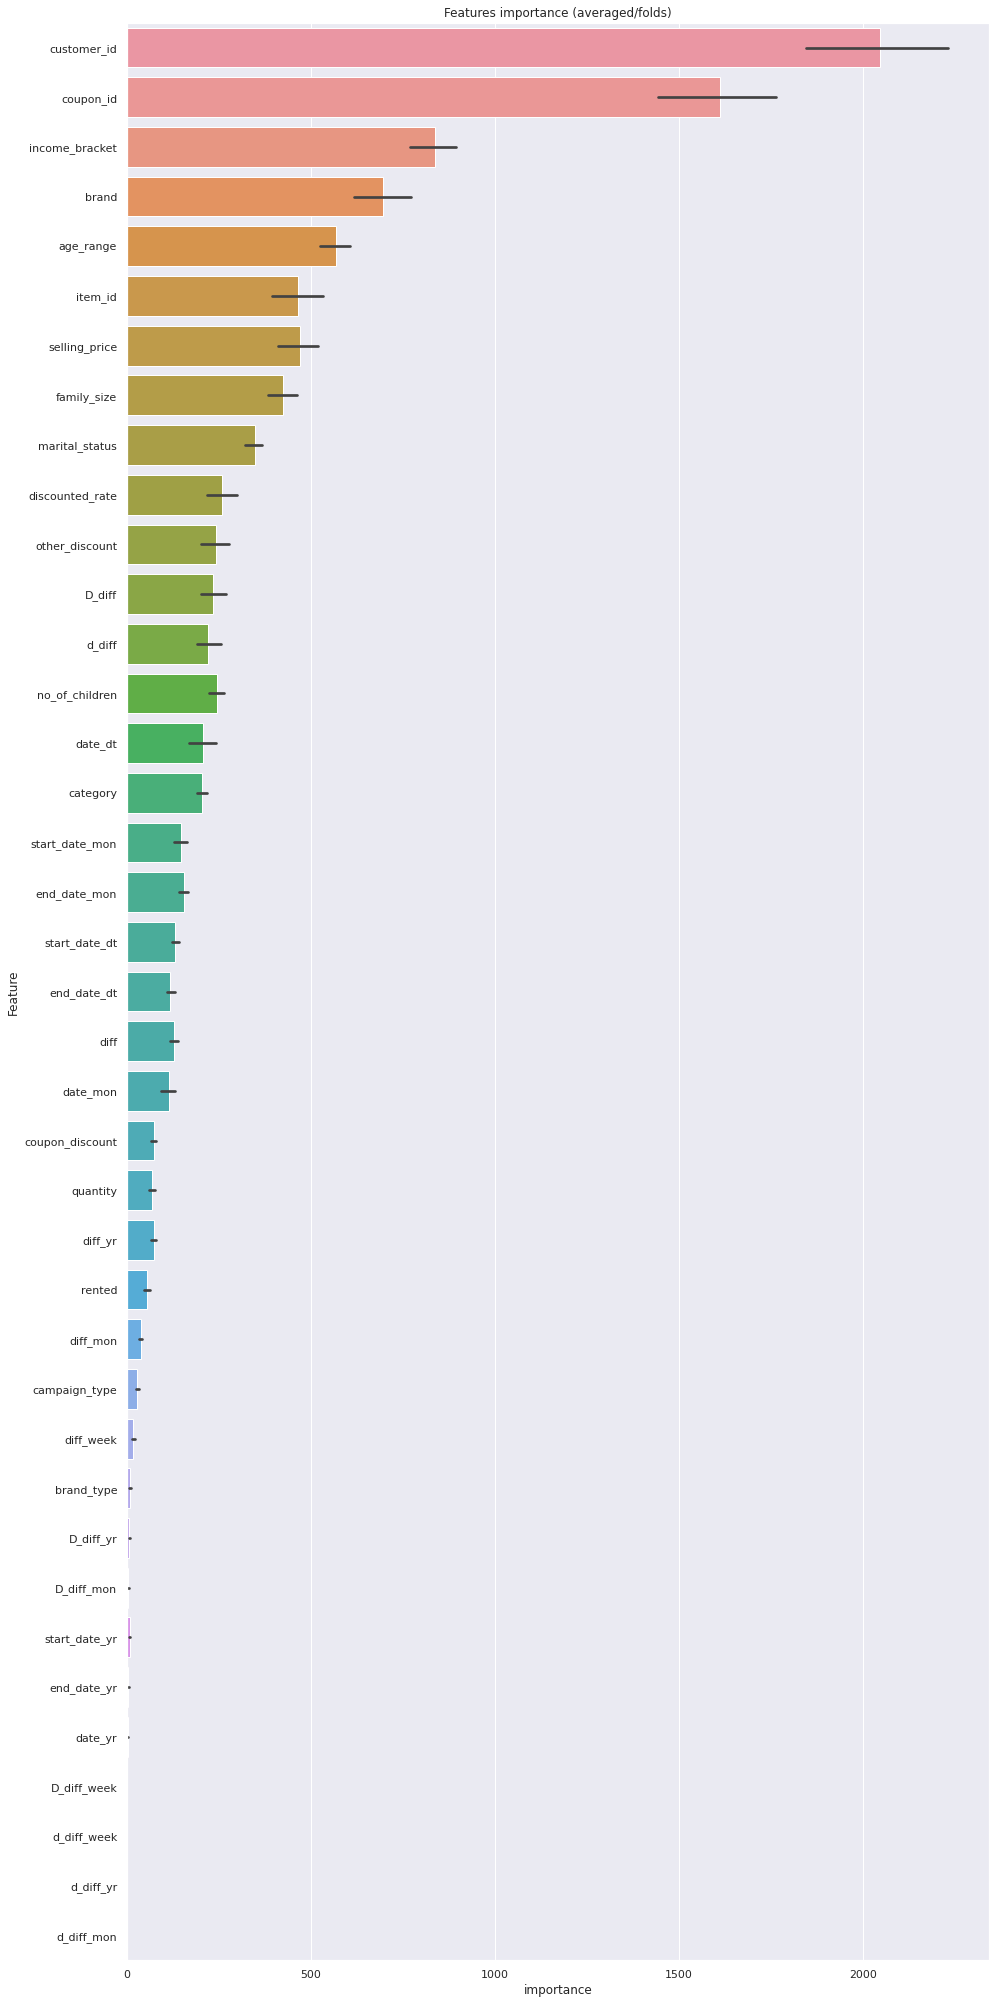

In [ ]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')


2. now comes the Group K fold on campaign_type with bayes hyperparameter optimization on LGBM 
there are 2 groups in which we can break the dataset.

['feature_fraction', 'lambda_l1', 'lambda_l2', 'learning_rate', 'max_depth', 'min_data_in_leaf', 'min_gain_to_split', 'min_sum_hessian_in_leaf', 'num_leaves']
----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 200 rounds.
[250]	valid_0's auc: 0.621853
Early stopping, best iteration is:
[51]	valid_0's auc: 0.630215
|  1        |  0.6302   |  0.4      |  1.188    |  4.121    |  0.2901   |  14.67    |  11.8     |  0.609    |  0.007758 |  14.62    |
Training until validation scores don't improve for 200 rounds.
[250]	valid_0's auc: 0.636906
[500]	valid_0's auc: 0.660929
[750]	valid_0's auc: 0.66335

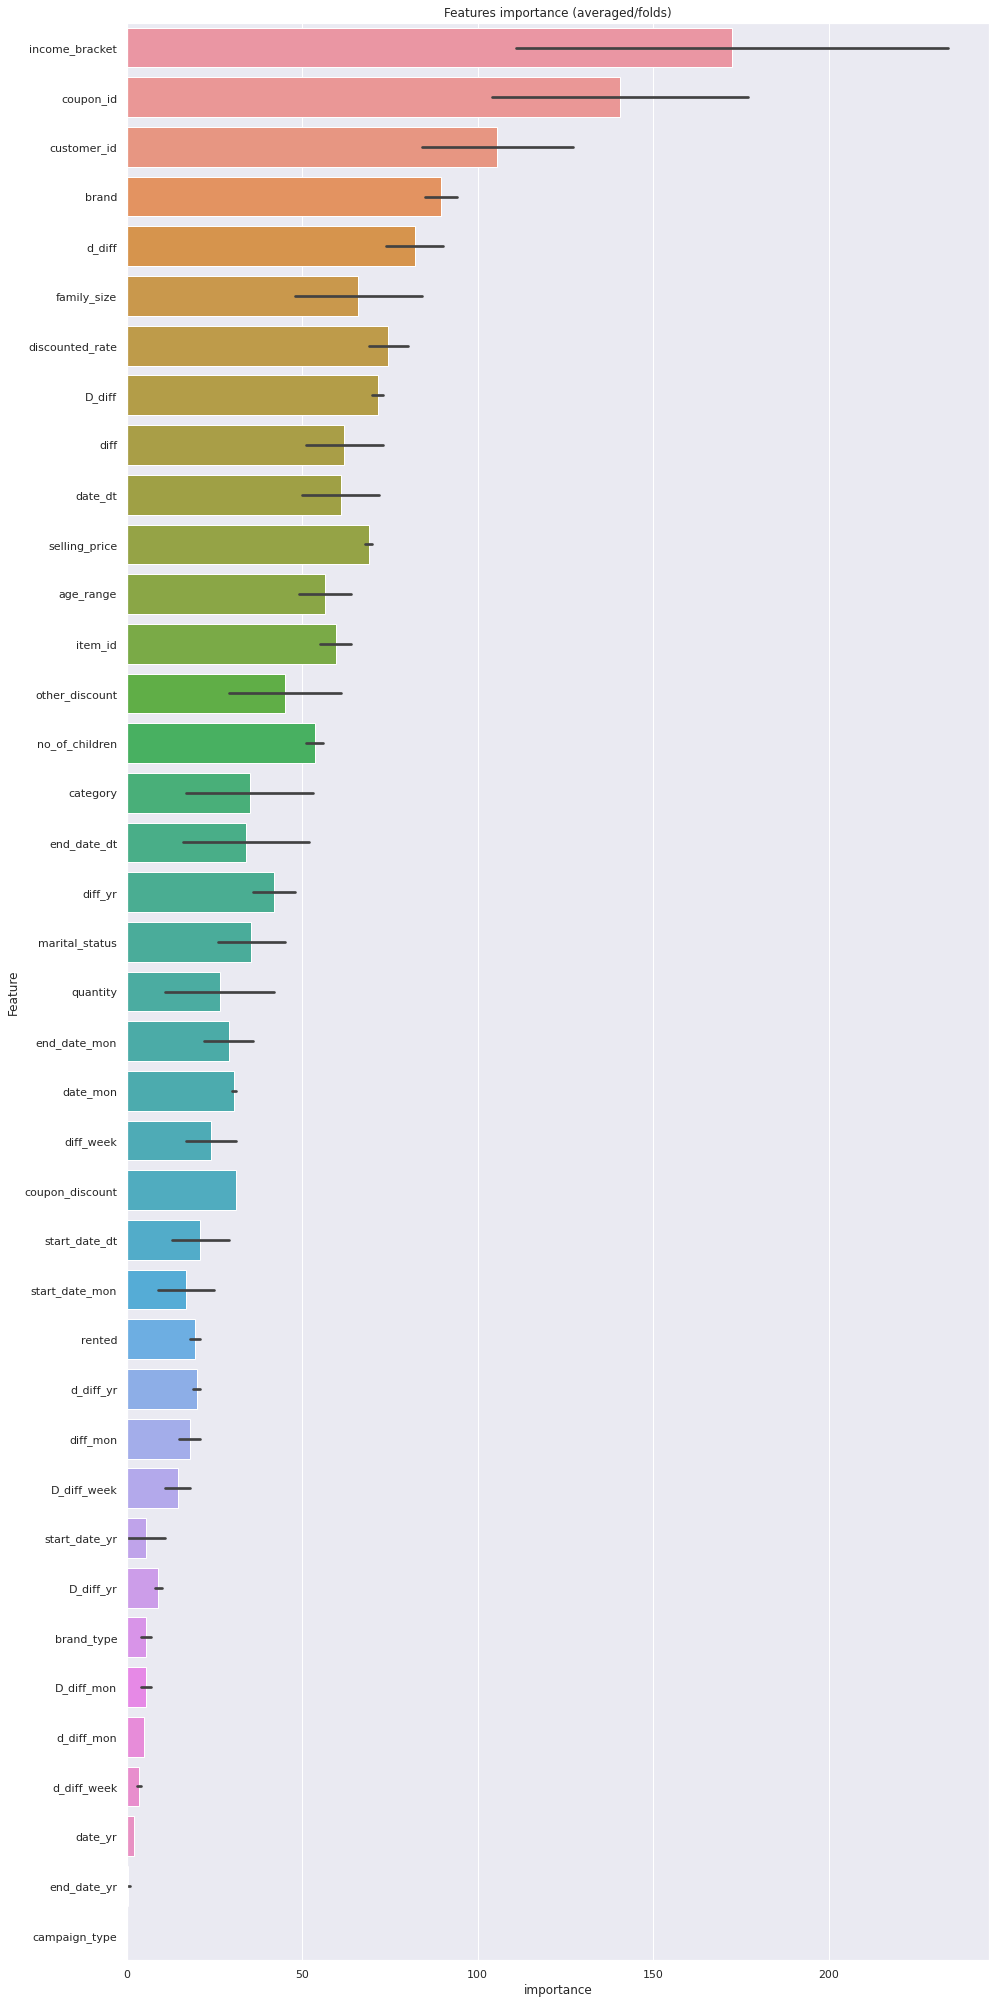

In [ ]:
from sklearn.model_selection import GroupKFold

df1 = df.drop(columns=['redemption_status'])
predictors = df1.columns[2:]
target = 'redemption_status'
bayesian_tr_index, bayesian_val_index  = list(GroupKFold(n_splits=2).split(df1[predictors], df[target].values ,df1['campaign_type'].values))[0]

train_df = df1[predictors]
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,   

    }    
    
    
    xg_train = lgb.Dataset(df1.iloc[bayesian_tr_index][predictors].values,
                           label=df.iloc[bayesian_tr_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(df1.iloc[bayesian_val_index][predictors].values,
                           label=df.iloc[bayesian_val_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )   

    num_round = 5000
    clf = lgb.train(param, xg_train, num_round, valid_sets =[xg_valid], verbose_eval=250, early_stopping_rounds = 200)
    
    predictions = clf.predict(df1.iloc[bayesian_val_index][predictors].values, num_iteration=clf.best_iteration)   
    
    score = metrics.roc_auc_score(df.iloc[bayesian_val_index][target].values, predictions)
    
    return score

# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15)}

from bayes_opt import BayesianOptimization

LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)
print(LGB_BO.space.keys)

init_points = 10
n_iter = 5

print('-' * 130)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

LGB_BO.probe(
    params={'feature_fraction': LGB_BO.max['params']['feature_fraction'], 
            'lambda_l1':LGB_BO.max['params']['lambda_l1'], 
            'lambda_l2': LGB_BO.max['params']['lambda_l2'], 
            'learning_rate': LGB_BO.max['params']['learning_rate'], 
            'max_depth': LGB_BO.max['params']['max_depth'], 
            'min_data_in_leaf': LGB_BO.max['params']['min_data_in_leaf'] ,
            'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'], 
            'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'], 
            'num_leaves': LGB_BO.max['params']['num_leaves']},
    lazy=True,
)

LGB_BO.maximize(init_points=0, n_iter=0) # remember no init_points or n_iter

for i, res in enumerate(LGB_BO.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(LGB_BO.max['target'])
print(LGB_BO.max['params'])


param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), # remember to int here
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), # remember to int here
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), # remember to int here
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)

oof = np.zeros(len(train_df))
#predictions = np.zeros((len(test_df),nfold))
feature_importance_df = pd.DataFrame()
    
i = 1
gfk = GroupKFold(n_splits=2)
for train_index, valid_index in gfk.split(df1[predictors], df[target].values ,df1['campaign_type'].values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(df1.iloc[train_index][predictors].values,
                           label=df.iloc[train_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(df1.iloc[valid_index][predictors].values,
                           label=df.iloc[valid_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )   

    
    clf = lgb.train(param_lgb, xg_train, 5000, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    oof[valid_index] = clf.predict(train_df.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = i
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions[:,i-1] += clf.predict(test_df[predictors], num_iteration=clf.best_iteration)
    i = i + 1

print("\n\nCV AUC: {:<0.2f}".format(metrics.roc_auc_score(df[target].values, oof)))

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

so the results are not very good the cv is .57 around which is just better than random in conclusion this strategy is not very good

3. now comes the Group K fold on coupon_id with bayes hyperparameter optimization on LGBM 
there are 18 groups(coupon_ids) on which k fold cross validation is done

['feature_fraction', 'lambda_l1', 'lambda_l2', 'learning_rate', 'max_depth', 'min_data_in_leaf', 'min_gain_to_split', 'min_sum_hessian_in_leaf', 'num_leaves']
----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[17]	valid_0's auc: 0.757512
|  1        |  0.7575   |  0.4      |  1.188    |  4.121    |  0.2901   |  14.67    |  11.8     |  0.609    |  0.007758 |  14.62    |
Training until validation scores don't improve for 200 rounds.
[250]	valid_0's auc: 0.657669
Early stopping, best iteration is:
[54]	valid_0's auc: 0.676458
|  2        |  0.6765   

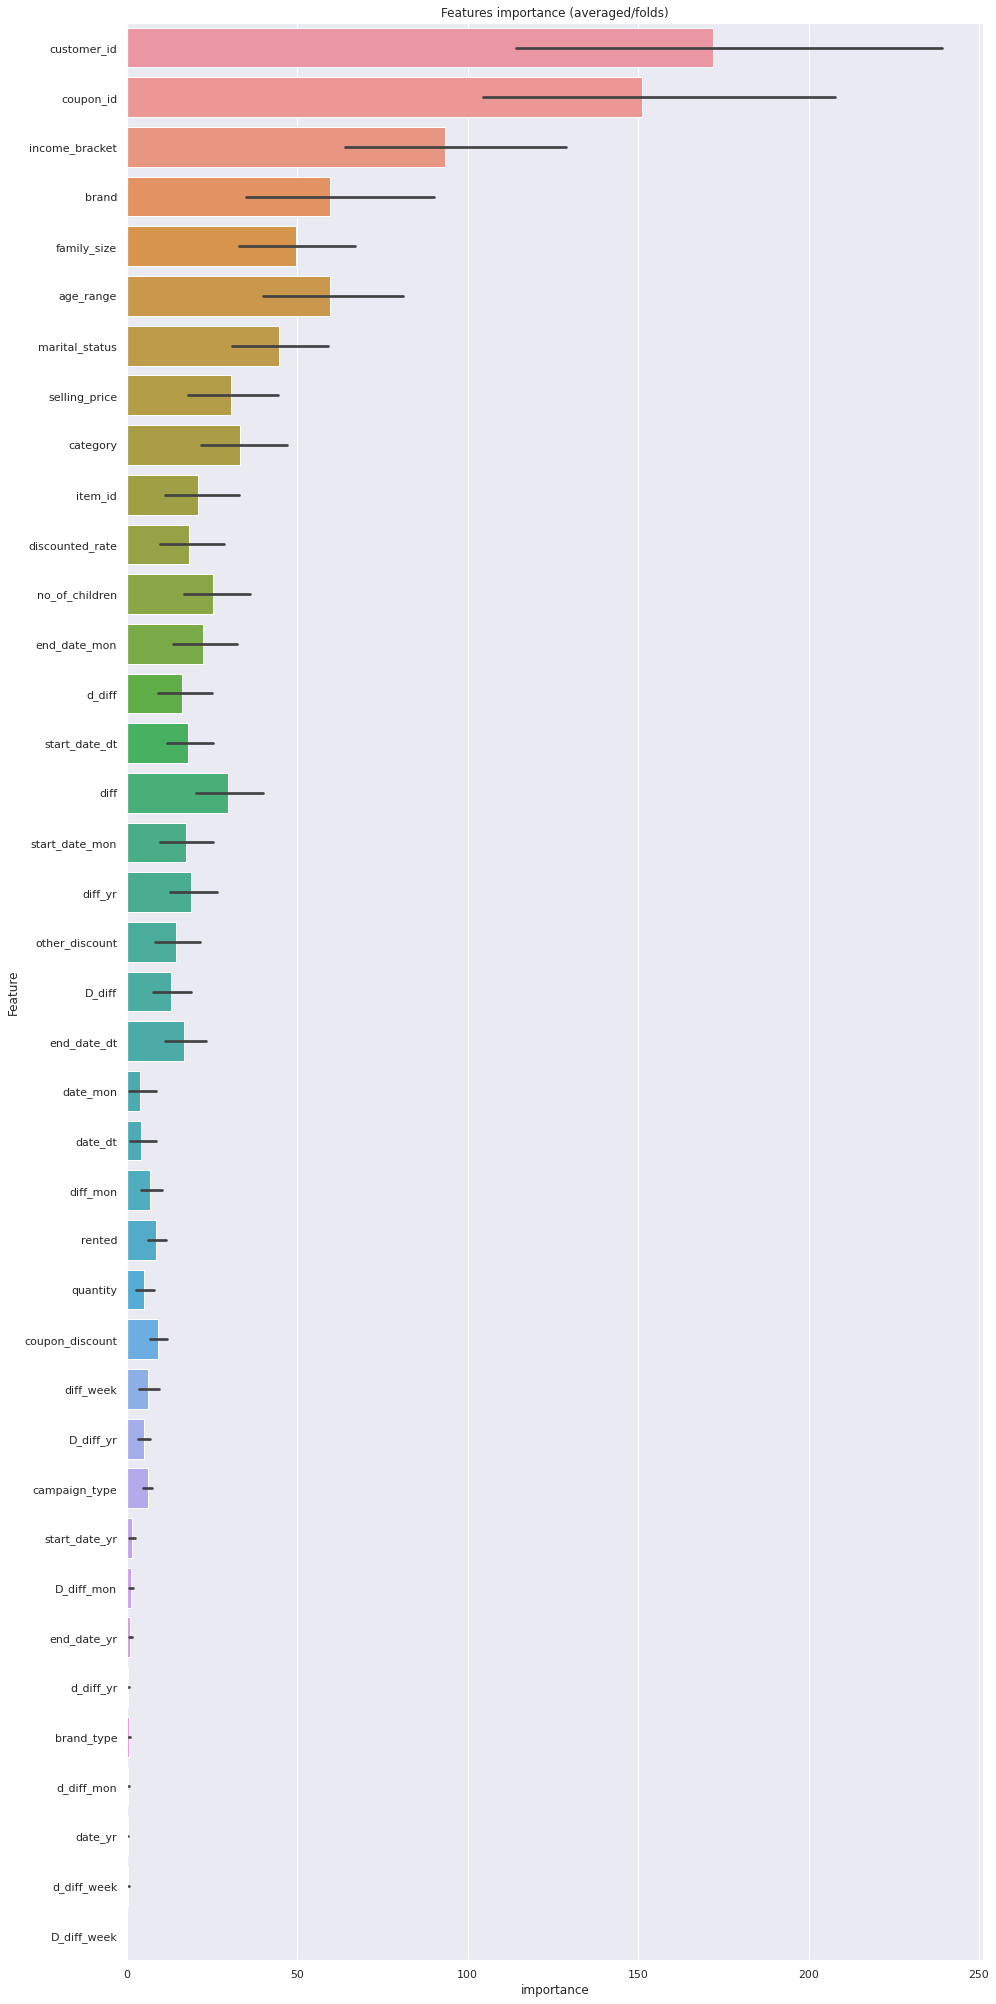

In [ ]:
from sklearn.model_selection import GroupKFold

df1 = df.drop(columns=['redemption_status'])
predictors = df1.columns[2:]
target = 'redemption_status'
bayesian_tr_index, bayesian_val_index  = list(GroupKFold(n_splits=18).split(df1[predictors], df[target].values ,df1['coupon_id'].values))[0]

train_df = df1[predictors]
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,   

    }    
    
    
    xg_train = lgb.Dataset(df1.iloc[bayesian_tr_index][predictors].values,
                           label=df.iloc[bayesian_tr_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(df1.iloc[bayesian_val_index][predictors].values,
                           label=df.iloc[bayesian_val_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )   

    num_round = 5000
    clf = lgb.train(param, xg_train, num_round, valid_sets =[xg_valid], verbose_eval=250, early_stopping_rounds = 200)
    
    predictions = clf.predict(df1.iloc[bayesian_val_index][predictors].values, num_iteration=clf.best_iteration)   
    
    score = metrics.roc_auc_score(df.iloc[bayesian_val_index][target].values, predictions)
    
    return score

# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15)}

from bayes_opt import BayesianOptimization

LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)
print(LGB_BO.space.keys)

init_points = 10
n_iter = 5

print('-' * 130)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

LGB_BO.probe(
    params={'feature_fraction': LGB_BO.max['params']['feature_fraction'], 
            'lambda_l1':LGB_BO.max['params']['lambda_l1'], 
            'lambda_l2': LGB_BO.max['params']['lambda_l2'], 
            'learning_rate': LGB_BO.max['params']['learning_rate'], 
            'max_depth': LGB_BO.max['params']['max_depth'], 
            'min_data_in_leaf': LGB_BO.max['params']['min_data_in_leaf'] ,
            'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'], 
            'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'], 
            'num_leaves': LGB_BO.max['params']['num_leaves']},
    lazy=True,
)

LGB_BO.maximize(init_points=0, n_iter=0) # remember no init_points or n_iter

for i, res in enumerate(LGB_BO.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(LGB_BO.max['target'])
print(LGB_BO.max['params'])


param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), # remember to int here
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), # remember to int here
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), # remember to int here
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)

oof = np.zeros(len(train_df))
#predictions = np.zeros((len(test_df),nfold))
feature_importance_df = pd.DataFrame()
    
i = 1
gfk = GroupKFold(n_splits=18)
for train_index, valid_index in gfk.split(df1[predictors], df[target].values ,df1['coupon_id'].values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(df1.iloc[train_index][predictors].values,
                           label=df.iloc[train_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(df1.iloc[valid_index][predictors].values,
                           label=df.iloc[valid_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )   

    
    clf = lgb.train(param_lgb, xg_train, 5000, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    oof[valid_index] = clf.predict(train_df.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = i
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions[:,i-1] += clf.predict(test_df[predictors], num_iteration=clf.best_iteration)
    i = i + 1

print("\n\nCV AUC: {:<0.2f}".format(metrics.roc_auc_score(df[target].values, oof)))

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

Okay so the AUC is .73 which is better than the group k fold of campaign_type but far less than stratified k fold

4. Splitting the data in 696 groups and doing all that we have done the same above

['feature_fraction', 'lambda_l1', 'lambda_l2', 'learning_rate', 'max_depth', 'min_data_in_leaf', 'min_gain_to_split', 'min_sum_hessian_in_leaf', 'num_leaves']
----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 200 rounds.
[250]	valid_0's auc: 0.826394
Early stopping, best iteration is:
[75]	valid_0's auc: 0.867435
|  1        |  0.8674   |  0.4      |  1.188    |  4.121    |  0.2901   |  14.67    |  11.8     |  0.609    |  0.007758 |  14.62    |
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.850645
|  2        |  0.8506   |

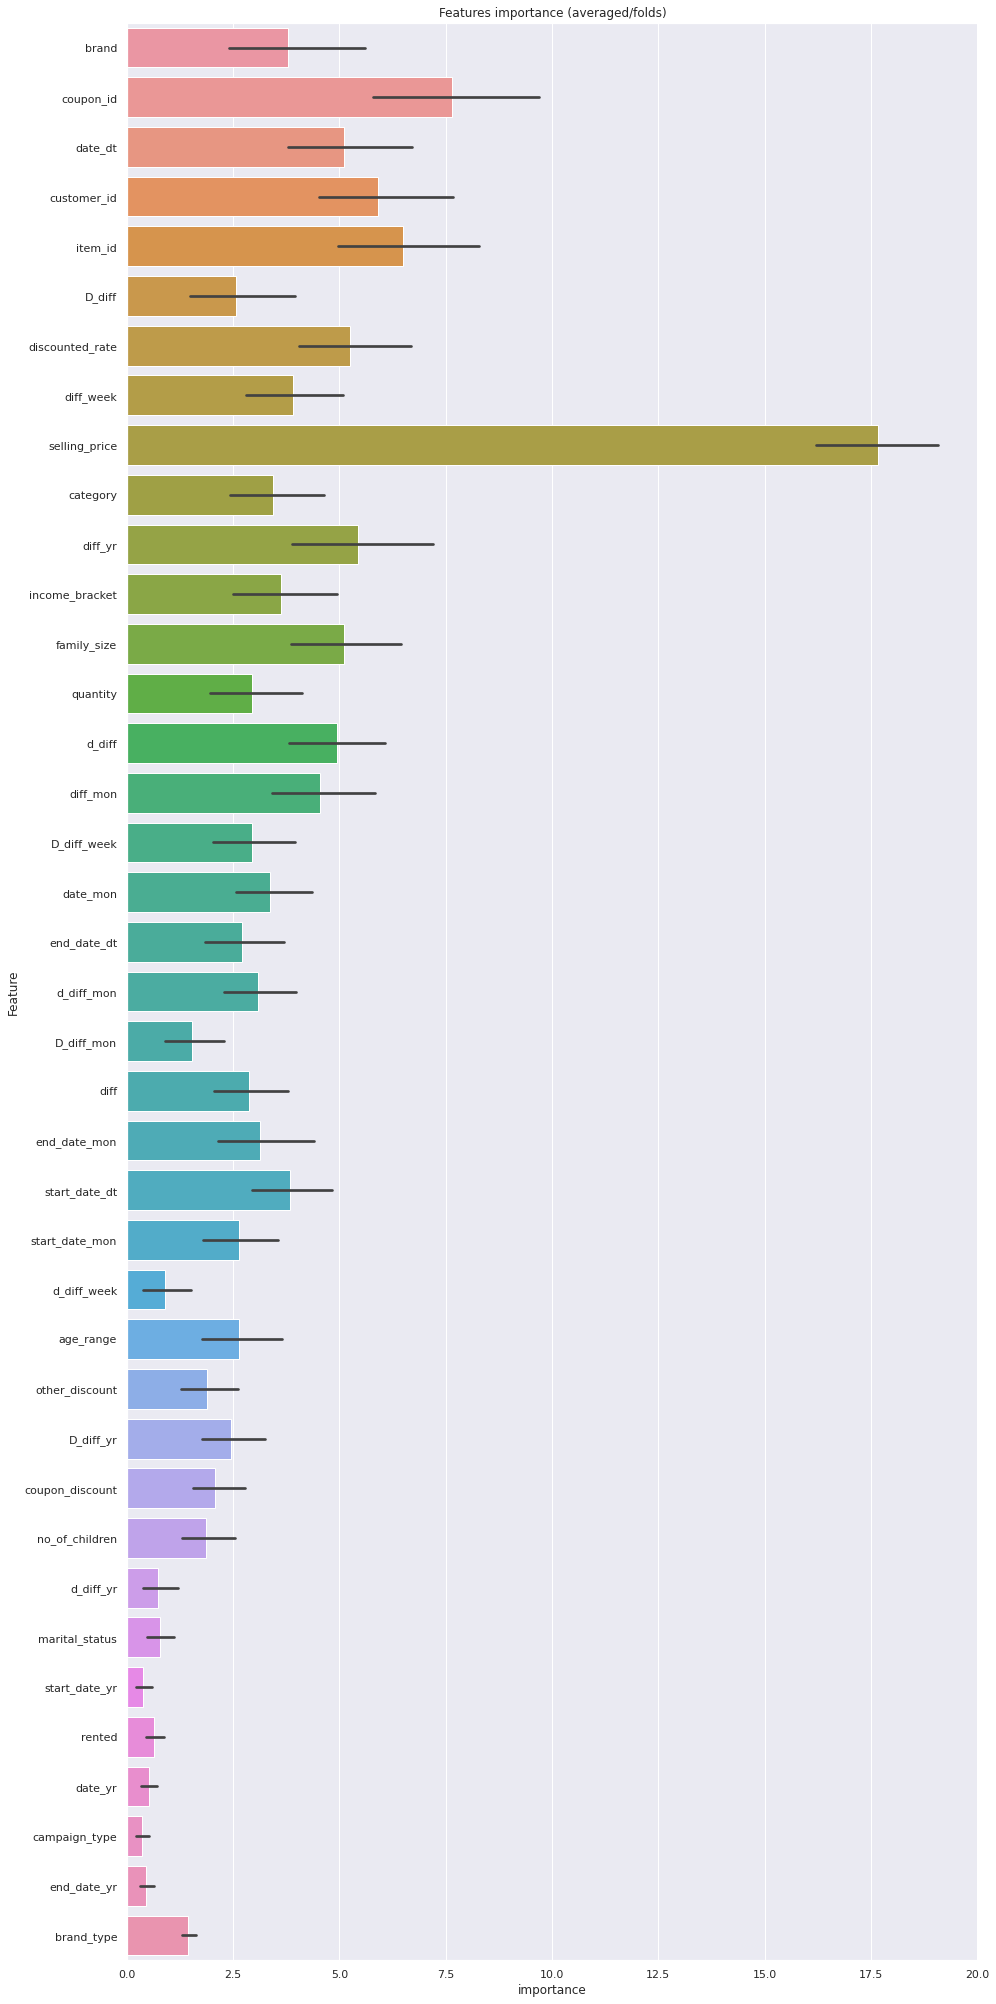

In [ ]:
from sklearn.model_selection import GroupKFold

df1 = df.drop(columns=['redemption_status'])
predictors = df1.columns[2:]
target = 'redemption_status'
bayesian_tr_index, bayesian_val_index  = list(GroupKFold(n_splits=len(set(df1['customer_id'].values))).split(df1[predictors], df[target].values ,df1['customer_id'].values))[0]

train_df = df1[predictors]
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,   

    }    
    
    
    xg_train = lgb.Dataset(df1.iloc[bayesian_tr_index][predictors].values,
                           label=df.iloc[bayesian_tr_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(df1.iloc[bayesian_val_index][predictors].values,
                           label=df.iloc[bayesian_val_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )   

    num_round = 5000
    clf = lgb.train(param, xg_train, num_round, valid_sets =[xg_valid], verbose_eval=250, early_stopping_rounds = 200)
    
    predictions = clf.predict(df1.iloc[bayesian_val_index][predictors].values, num_iteration=clf.best_iteration)   
    
    score = metrics.roc_auc_score(df.iloc[bayesian_val_index][target].values, predictions)
    
    return score

# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15)}

from bayes_opt import BayesianOptimization

LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)
print(LGB_BO.space.keys)

init_points = 10
n_iter = 5

print('-' * 130)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

LGB_BO.probe(
    params={'feature_fraction': LGB_BO.max['params']['feature_fraction'], 
            'lambda_l1':LGB_BO.max['params']['lambda_l1'], 
            'lambda_l2': LGB_BO.max['params']['lambda_l2'], 
            'learning_rate': LGB_BO.max['params']['learning_rate'], 
            'max_depth': LGB_BO.max['params']['max_depth'], 
            'min_data_in_leaf': LGB_BO.max['params']['min_data_in_leaf'] ,
            'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'], 
            'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'], 
            'num_leaves': LGB_BO.max['params']['num_leaves']},
    lazy=True,
)

LGB_BO.maximize(init_points=0, n_iter=0) # remember no init_points or n_iter

for i, res in enumerate(LGB_BO.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(LGB_BO.max['target'])
print(LGB_BO.max['params'])


param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), # remember to int here
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), # remember to int here
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), # remember to int here
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)

oof = np.zeros(len(train_df))
#predictions = np.zeros((len(test_df),nfold))
feature_importance_df = pd.DataFrame()
    
i = 1
gfk = GroupKFold(n_splits=len(set(df1['customer_id'].values)))
for train_index, valid_index in gfk.split(df1[predictors], df[target].values ,df1['customer_id'].values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(df1.iloc[train_index][predictors].values,
                           label=df.iloc[train_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(df1.iloc[valid_index][predictors].values,
                           label=df.iloc[valid_index][target].values,
                           feature_name=list(predictors),
                           free_raw_data = False
                           )   

    
    clf = lgb.train(param_lgb, xg_train, 5000, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    oof[valid_index] = clf.predict(train_df.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = i
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions[:,i-1] += clf.predict(test_df[predictors], num_iteration=clf.best_iteration)
    i = i + 1

print("\n\nCV AUC: {:<0.2f}".format(metrics.roc_auc_score(df[target].values, oof)))

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

Surprisingly we have got good results from this split(696 splits)AUC=.79 in comparison from the other group k fold on coupon_id splits (18 groups)AUC=.73

## final thoughts

1. More feature engineering could be done in terms of creating more categorical features
2. Using models like catboost and Neural Networks would help in getting some good results on the group k folds where lgbm performs bad
3. Using ensembles like power ensemble and rank averaging can help

#### Thanks for test really polish my skills will wait for your reply